# Wake word detection
This notebook runs through the steps needed to implement a wake-word detector. A wake word detector is used to trigger an event in a program upon the utterance of a specific word. The method with which this is achieved here is using a deep recurrent neural network based on gated recurrent units that takes as an input an audio clip of 10 seconds and returns an audio clip which rings a bell if the wake word was uttered. 

This notebook makes use of the model and pre-trained weights from the coursera course on sequential models. 

The notebook is organized as follows:

- [0. Imports](#0)
- [1. Record audio samples for trigger, negatives, background, and test sets](#1)
- [2. Synthesize training and test sets](#2)
- [3. Build the model (with gated recurrent units)](#3)
- [4. Load pre-trained weights](#4)
- [5. Fine-tune the model](#5)
- [6. Evaluation and prediction](#6)

<a name='0'></a>
## 0. Imports
This notebook requires `tensorflow`, `pydub`, `numpy` and `scipy`. For in-notebook recording of audio (in [section 1](#1)), `sounddevice`, `soundfile`, `ipywebrtc`, and `ffmpeg` are required in addtion.

The local module `utils` contains various functions required for this notebook.

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from utils import *
%matplotlib inline

<a name='1'></a>
## 1. Record audio samples

#### 1.1 Record wake word and negatives
Record multiple trigger words and negatives using `ipywebrtc`. If the pre-trained weights are going to be used, the wake word is '**activate**'. 

In [2]:
from ipywebrtc import AudioRecorder, CameraStream

In [3]:
audiodevice = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=audiodevice)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [4]:
pathwake = 'audio/trigger/'
pathnegative = 'audio/negatives/'

# Uncomment the savesample for the wake word or negative. Make sure that
# only one is uncommented.

# wake word
#savesample(recorder, pathwake)

# negative word
#savesample(recorder, pathnegative)

#### 1.2 Record background and test audio samples
These need to be 10s long and are recorded with `sounddevice`.

In [5]:
samplerate = 44100
duration = 10
backgroundpath = 'audio/backgrounds/'
testpath = 'audio/test/'

# Uncomment the savesample for the wake word or negative. Make sure that
# only one is uncommented.

# background
#recordsample(backgroundpath, duration, samplerate)

# test set
#recordsample(testpath, duration, samplerate)


#### 1.3 Listen to audio files

In [6]:
#IPython.display.Audio("./audio/trigger/s_1.wav")
#IPython.display.Audio("./audio/negatives/s_1.wav")
#IPython.display.Audio("./audio/backgrounds/1.wav")
#IPython.display.Audio("./audio/test/1.wav")

<a name='2'></a>
## 2. Synthesize training and test sets

To generate a larger data set from the samples one can superimpose various wake words and negative words with the recorded backgrounds. The input data of the recurrent network is spectral and can be obtained by supplying the raw audio data to the function `graph_spectrogram`. 

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


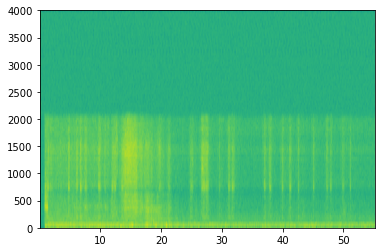

In [7]:
x = graph_spectrogram("audio/backgrounds/1.wav")
_, data = wavfile.read("audio/backgrounds/1.wav")
print("Time steps in audio recording before spectrogram", data.shape)
print("Time steps in input after spectrogram", x.shape)

The relevant dimensions of the problem are:  

In [8]:
s_freq = 44100  # sampling frequency
Tx = 5511 # The number of time steps input from the spectrogram
n_freq = 101 # Number of frequencies input at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

#### 2.1 Load audio samples

In [9]:
import os

path = './audio/'
triggers = []
backgrounds = []
negatives = []
for filename in os.listdir(path + "trigger"):
    if filename.endswith("wav"):
        trigger = AudioSegment.from_wav(path + "trigger/" + filename)
        assert trigger.frame_rate==s_freq, f"All audio files must be sampled at {s_freq}Hz"
        triggers.append(trigger)
for filename in os.listdir(path + "backgrounds"):
    if filename.endswith("wav"):
        background = AudioSegment.from_wav(path + "backgrounds/" + filename)
        assert trigger.frame_rate==s_freq, f"All audio files must be sampled at {s_freq}Hz"
        backgrounds.append(background)
for filename in os.listdir(path + "negatives"):
    if filename.endswith("wav"):
        negative = AudioSegment.from_wav(path + "negatives/" + filename)
        assert trigger.frame_rate==s_freq, f"All audio files must be sampled at {s_freq}Hz"
        negatives.append(negative)

print("Number of background samples: \n" + str(len(backgrounds)),"\n")
print("Number of wake word samples \n" + str(len(triggers)),"\n")
print("Number of negative samples \n" + str(len(negatives)),"\n")

Number of background samples: 
2 

Number of wake word samples 
2 

Number of negative samples 
3 



#### 2.2 Generate training set

0
10
20
30
40
50
60


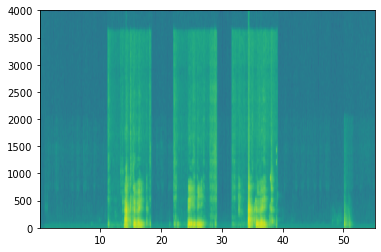

In [10]:
np.random.seed(454)
nsamples = 64
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], triggers, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

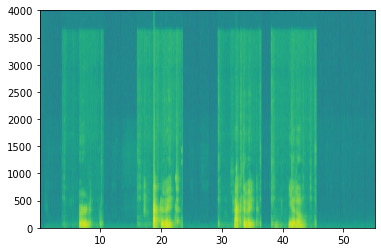

In [11]:
# Set the random seed
np.random.seed(18)
x, y = create_training_example(backgrounds[0], triggers, negatives, Ty)

Generated training set example:

In [12]:
IPython.display.Audio("train.wav")

The output data of the model is a vector containing ones at the time stamps right after the wake word was said:

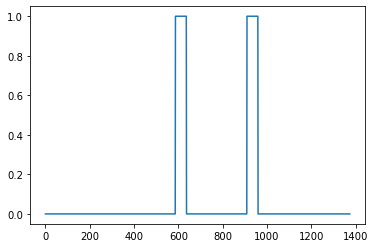

In [13]:
plt.plot(y.swapaxes(0,1))

#### 2.3 Generate dev set

0


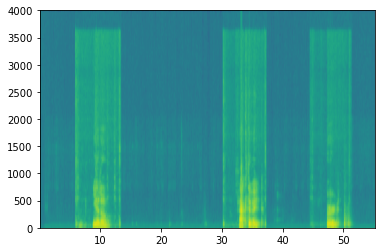

In [14]:
path = 'audio/dev/'
for filename in os.listdir(path):
    if filename.endswith("wav"):
        os.remove(path+filename)

nsamples = 8
X_dev = []
Y_dev = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], triggers, negatives, Ty, path)
    X_dev.append(x.swapaxes(0,1))
    Y_dev.append(y.swapaxes(0,1))
    
X_dev = np.array(X)
Y_dev = np.array(Y)

<a name='3'></a>
## 3. Build the model (with gated recurrent units)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [16]:
def modelf(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Convolutional layer
    X = Conv1D(filters=196,kernel_size=15,strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.8)(X)                                  

    # First GRU Layer
    X = GRU(units=128, return_sequences=True)(X)
    X = Dropout(rate=0.8)(X) 
    X = BatchNormalization()(X)                           
    
    # Second GRU Layer
    X = GRU(units=128, return_sequences=True)(X)
    X = Dropout(rate=0.8)(X)        
    X = BatchNormalization()(X)   
    X = Dropout(rate=0.8)(X)                                    
    
    #Time-distributed dense layer
    X = TimeDistributed(Dense(1, activation='sigmoid'))(X) 

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [17]:
model = modelf(input_shape = (Tx, n_freq))

In [18]:
#model.summary()

<a name='4'></a>
## 4. Load pre-trained weights

In [19]:
from tensorflow.keras.models import model_from_json

json_file = open('./models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('./models/model.h5')

<a name='5'></a>
## 5. Fine-tune the model
Freeze BatchNorm layers for fine-tuning of loaded model 

In [20]:
model.layers[2].trainable = False
model.layers[7].trainable = False
model.layers[10].trainable = False

Use Adam optimizer and binary crossentropy loss function.

In [21]:
opt = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [22]:
history = model.fit(X, Y, batch_size = 16, epochs=4)

Epoch 1/4
4/4 [==============================] - 8s 1s/step - loss: 0.2164 - accuracy: 0.9330
Epoch 2/4
4/4 [==============================] - 6s 2s/step - loss: 0.2134 - accuracy: 0.9319
Epoch 3/4
4/4 [==============================] - 6s 2s/step - loss: 0.2143 - accuracy: 0.9329
Epoch 4/4
4/4 [==============================] - 7s 2s/step - loss: 0.2095 - accuracy: 0.9327


<a name='6'></a>
## 6. Evaluation and prediction

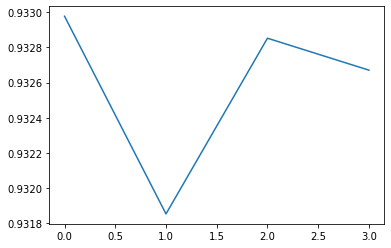

In [23]:
plt.plot(history.history['accuracy'])

#### 6.1 Dev set performance

In [24]:
loss, acc, = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

2/2 [==============================] - 2s 802ms/step - loss: 0.1787 - accuracy: 0.9296
Dev set accuracy =  0.9295568466186523


#### 6.1 Test set prediction

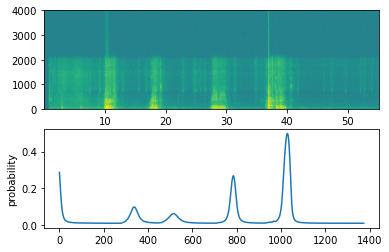

In [25]:
filename = "./audio/test/1.wav"
prediction = detect_wakeword(model, filename)
bell_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./bell_output.wav")